## Classification

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

no display found. Using non-interactive Agg backend


In [2]:
LOAN_DATA_CSV = './data/loan_data.csv.gz'

### Naive solution

In [3]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

In [4]:
loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [5]:
# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'

In [6]:
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model = MultinomialNB(alpha=0, fit_prior=False)
naive_model.fit(X, y)

new_loan = X.loc[146:146, :]
print('predicted class: ', naive_model.predict(new_loan)[0])

probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
print(probabilities)

predicted class:  default
predicted probabilities
    default  paid off
0  0.653699  0.346301


/Users/v0m01sk/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


In [7]:
X.loc[146:146, :]

,credit_card,debt_consolidation,home_improvement,major_purchase,medical,other,small_business,MORTGAGE,OWN,RENT,< 1 Year,> 1 Year
146,0,0,0,0,0,0,1,1,0,0,0,1


# Discriminant Analysis
## A Simple Example

In [8]:
LOAN3000_CSV = './data/loan3000.csv'
loan3000 = pd.read_csv(LOAN3000_CSV)
loan3000.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


In [9]:
loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [10]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


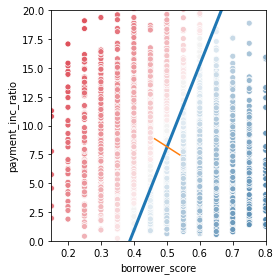

In [12]:
# Use scalings and center of means to determine decision boundary
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df, 
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

# Logistic regression
## Logistic Response Function and Logit

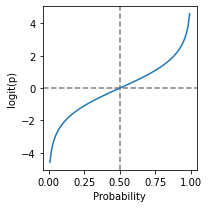

In [14]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()

## Logistic Regression and the GLM
The package _scikit-learn_ has a specialised class for `LogisticRegression`. _Statsmodels_ has a more general method based on generalized linear model (GLM).

In [15]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  -1.6378908649112442
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079739
borrower_score,4.612183
debt_consolidation,-0.249414
home_improvement,-0.407734
major_purchase,-0.229710
medical,-0.510744
other,-0.620800
small_business,-1.214936
OWN,-0.048211
RENT,-0.157288


In [16]:
print(loan_data['purpose_'].cat.categories)
print(loan_data['home_'].cat.categories)
print(loan_data['emp_len_'].cat.categories)

Index(['credit_card', 'debt_consolidation', 'home_improvement',
       'major_purchase', 'medical', 'other', 'small_business'],
      dtype='object')
Index(['MORTGAGE', 'OWN', 'RENT'], dtype='object')
Index([' < 1 Year', ' > 1 Year'], dtype='object')


In [17]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

logit_reg_enc = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

print('intercept ', logit_reg_enc.intercept_[0])
print('classes', logit_reg_enc.classes_)
pd.DataFrame({'coeff': logit_reg_enc.coef_[0]}, 
             index=X.columns)

intercept  1.6380885430318344
classes [0. 1.]


,coeff
payment_inc_ratio,0.079728
borrower_score,-4.611037
debt_consolidation,0.249342
home_improvement,0.407614
major_purchase,0.229376
medical,0.510087
other,0.620534
small_business,1.215662
OWN,0.048453
RENT,0.157355


## Assessing the Model
For comparison, here the GLM model using _statsmodels_. This method requires that the outcome is mapped to numbers. 

In [18]:
# use GLM (general linear model) with the binomial family to 
# fit a logistic regression
y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), 
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Mon, 06 Dec 2021   Deviance:                       57515.
Time:                        12:16:03   Pearson chi2:                 4.54e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0

In [19]:
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45321
Model Family:                                       Binomial   Df Model:                           20
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28731.
Date:                                       Mon, 06 Dec 2021   Deviance:                       57462.
Time:                                               12:16:53   Pearson chi2:                 4.54e+04
No. Iterations:                                            6                                         
Covariance Type:                                   nonrobust                      

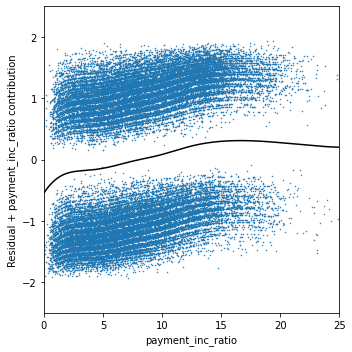

In [20]:
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)


plt.tight_layout()
plt.show()

# Evaluating Classification Models
## Confusion Matrix

In [21]:
# Confusion matrix
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default            14337             8334
Y = paid off            8149            14522


In [22]:
print(confusion_matrix(y, logit_reg.predict(X)))

[[14337  8334]
 [ 8149 14522]]


In [23]:
classificationSummary(y, logit_reg.predict(X), 
                      class_names=logit_reg.classes_)

Confusion Matrix (Accuracy 0.6365)

         Prediction
  Actual  default paid off
 default    14337     8334
paid off     8149    14522


## Precision, Recall, and Specificity
The _scikit-learn_ function `precision_recall_fscore_support` returns
precision, recall, fbeta_score and support. 

In [25]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precision', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('Recall', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Specificity', conf_mat[1, 1] / sum(conf_mat[1, :]))

Precision 0.6375967268522637
Recall 0.6323938070662961
Specificity 0.640554011733051


In [26]:
precision_recall_fscore_support(y, logit_reg.predict(X), 
                                labels=['default', 'paid off'])

(array([0.63759673, 0.63536927]),
 array([0.63239381, 0.64055401]),
 array([0.63498461, 0.63795111]),
 array([22671, 22671]))

# Strategies for Imbalanced Data
## Undersampling
> The results differ from the R version, however are equivalent to results obtained using the R code. Model based results are of similar magnitude.

In [42]:
FULL_TRAIN_SET_CSV = './data/full_train_set.csv.gz'
full_train_set = pd.read_csv(FULL_TRAIN_SET_CSV)

In [43]:
print('percentage of loans in default: ', 
print(      100 * np.mean(full_train_set.outcome == 'default')))

18.894546909248504
percentage of loans in default:  None


In [44]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = full_train_set[outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y)
print('percentage of loans predicted to default: ', 
print(      100 * np.mean(full_model.predict(X) == 'default')))

0.1525165226232842
percentage of loans predicted to default:  None


In [45]:
(np.mean(full_train_set.outcome == 'default') / 
 np.mean(full_model.predict(X) == 'default'))

123.88524590163935

## Oversampling and Up/Down Weighting

In [46]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
wt = [default_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome]

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X, y, wt)
print('percentage of loans predicted to default (weighting): ', 
print(      100 * np.mean(full_model.predict(X) == 'default')))

61.79836148916132
percentage of loans predicted to default (weighting):  None


In [47]:
(np.mean(full_train_set.outcome == 'default') / 
 np.mean(full_model.predict(X) == 'default'))

0.30574511126095755

## Data Generation
The package _imbalanced-learn_ provides an implementation of the _SMOTE_ and similar algorithms. 

In [48]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print('percentage of loans in default (SMOTE resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (SMOTE): ', 
      100 * np.mean(full_model.predict(X) == 'default'))


X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print('percentage of loans in default (ADASYN resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (ADASYN): ', 
print(      100 * np.mean(full_model.predict(X) == 'default')))

percentage of loans in default (SMOTE resampled):  50.0
percentage of loans predicted to default (SMOTE):  29.14482402260245
percentage of loans in default (ADASYN resampled):  48.56040383751355
27.884687507813343
percentage of loans predicted to default (ADASYN):  None
